<a href="https://colab.research.google.com/github/sravanreddy6745/Traffic-Sign-Classification/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrafficSignClassification

**Import Required Libraries**

In [105]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
#from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix


**Pipeline architecture:**



1.   **Load The Data.**
2.   **Dataset Summary & Exploration**
3.   **Data Preprocessing.**
       *   Shuffling
       *   Grayscaling.
       *   Local Histogram Equalization.
       *   Normalization.
2. **Design a Model Architecture**
       *   VGGNet
1.   **Model Training and Evaluation.**
2.   **Testing the Model Using the Test Set.**
1.   **Testing the Model on New Images.**









**Step 1: Load The Data**

Download the dataset from [here](`https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip`). This is a pickled dataset in which we've already resized the images to 32x32.


We already have three .p files of 32x32 resized images:
*   train.p: The training set
*   test.p: The testing set.
*   valid.p: The validation set.

We will use Python pickle to load the data.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the data as train, test & valadition.

**Data Set Summary & Exploration:**                      
 basic information of the data set,



*   The size of training set is 34799
*   The size of the validation set is 4410
*   The size of test set is 12630
*   The shape of a traffic sign image is 32x32x3
*   The number of unique classes/labels in the data set is 43





In [4]:
#import train data
with open('/content/drive/My Drive/Traffic-Sign-Classification/traffic-signs-data/train.p', 'rb') as f:
    train_data = pickle.load(f)
    
with open('/content/drive/My Drive/Traffic-Sign-Classification/traffic-signs-data/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('/content/drive/My Drive/Traffic-Sign-Classification/traffic-signs-data/test.p', 'rb') as f:
    test_data = pickle.load(f)
    


The pickled data is a dictionary with 4 key/value pairs:


*   'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
*   'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.

*      'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
*   'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print("Training data  shape",X_train.shape)
print("Test data   shape",X_test.shape)
print("validation  data shpe",X_val.shape)

Training data  shape (34799, 32, 32, 3)
Test data   shape (12630, 32, 32, 3)
validation  data shpe (4410, 32, 32, 3)


# Visualising the data

(32, 32, 3)


37

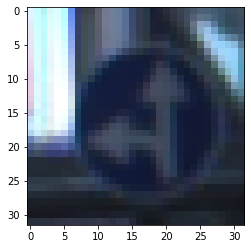

In [11]:
i=np.random.randint(1,len(X_train))
plt.imshow(X_train[i])
print(X_train[i].shape)
y_train[i]

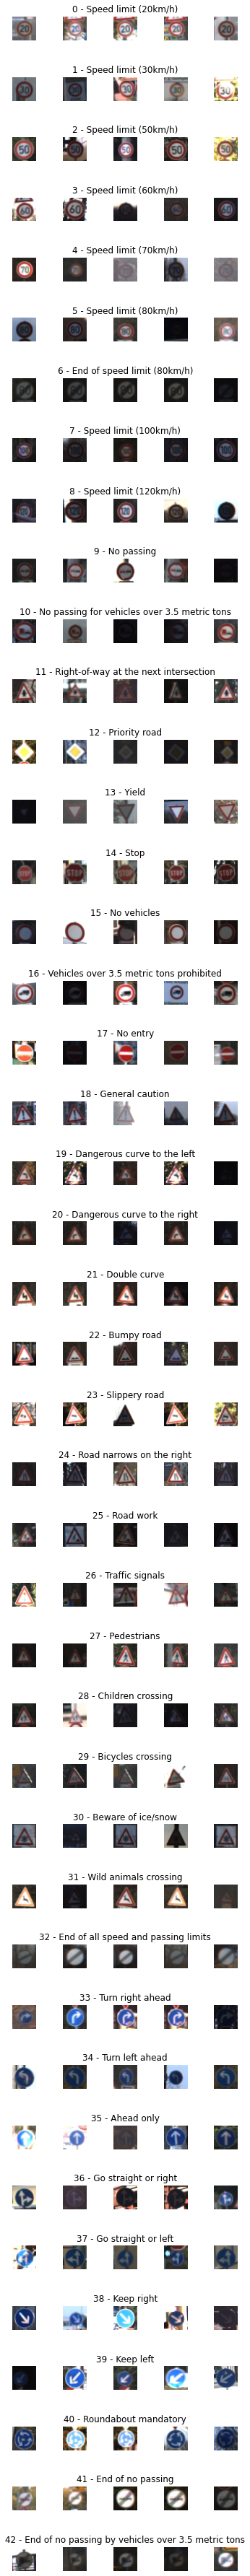

In [12]:
data = pd.read_csv('/content/drive/My Drive/Traffic-Sign-Classification/signnames.csv')
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


In [19]:


def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=43)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()



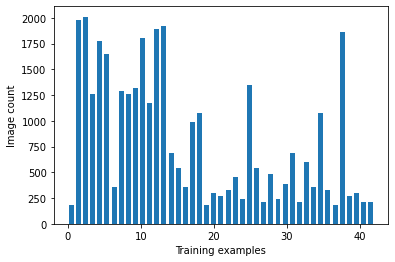

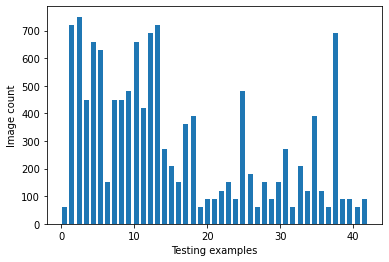

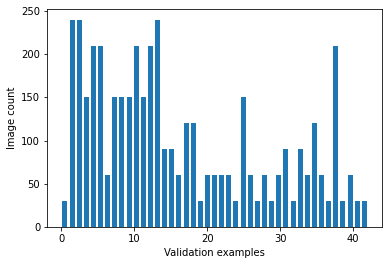

In [21]:
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_val, "Validation examples")

In [24]:
X_train, y_train = shuffle(X_train, y_train)

In [25]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


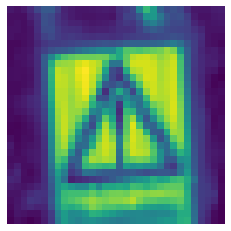

In [26]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)


In [27]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img


(32, 32)


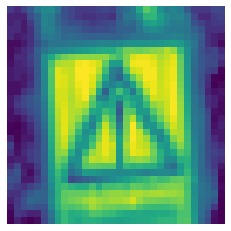

In [28]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)


In [29]:
def preprocess(img):
    #img = grayscale(img)
    #img = equalize(img)
    img = img/255
    return img


In [30]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))


(34799, 32, 32, 3)


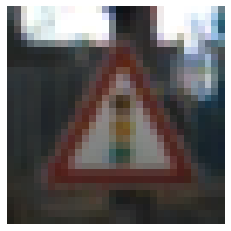

In [31]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)


In [32]:
X_train = X_train.reshape(34799, 32, 32,3)
X_test = X_test.reshape(12630, 32, 32,3)
X_val = X_val.reshape(4410, 32, 32,3)


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)


In [34]:
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)


(15, 32, 32, 3)


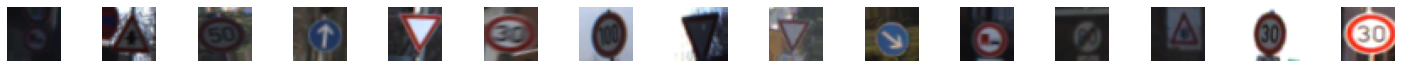

In [35]:
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32,3))
    axs[i].axis("off")
 
print(X_batch.shape)



In [36]:
from tensorflow.keras import utils as np_utils

In [37]:
y_train = np_utils.to_categorical(y_train, 43)
y_test = np_utils.to_categorical(y_test, 43)
y_val = np_utils.to_categorical(y_val, 43)


# MODEL CREATION -VGG



**Our model is adapted from the VGG as follows**


*   The inputs are 32x32 (RGB - 3 channels) images
*       The activation function is ReLU except for the output layer which uses Softmax

*  The output has 43 classes




In [49]:
def modified_model():
  model = Sequential()
  model.add(layers.Conv2D(96, (5, 5), input_shape=(32, 32, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(112, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.2))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(268, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(43, activation='softmax'))
  
  model.compile(keras.optimizers.Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [55]:
from keras.models import Sequential
from tensorflow.keras import layers,datasets,models

from tensorflow import keras
model=modified_model()

In [40]:
from tensorflow.keras import layers,models


In [56]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
2175/2175 [==============================] - 14s 7ms/step - loss: 0.9835 - accuracy: 0.7152 - val_loss: 0.2911 - val_accuracy: 0.9181
Epoch 2/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.1295 - accuracy: 0.9611 - val_loss: 0.2030 - val_accuracy: 0.9490
Epoch 3/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.0743 - accuracy: 0.9772 - val_loss: 0.1371 - val_accuracy: 0.9601
Epoch 4/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.0541 - accuracy: 0.9836 - val_loss: 0.0980 - val_accuracy: 0.9692
Epoch 5/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.1693 - val_accuracy: 0.9658
Epoch 6/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.2373 - val_accuracy: 0.9553
Epoch 7/10
2175/2175 [==============================] - 14s 6ms/step - loss: 0.0331 - accuracy: 0.9905 - val_loss: 0.3325 - val_ac

Text(0.5, 0, 'epoch')

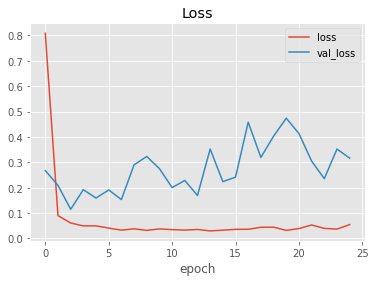

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('epoch')


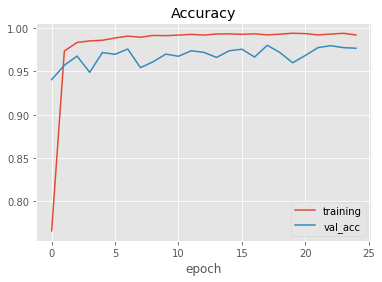

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.style.use('ggplot')


In [54]:
score=model.evaluate(X_test,y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.6276 - accuracy: 0.9539


In [ ]:
score

[0.3997039794921875, 0.9507521986961365]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_accuracy']

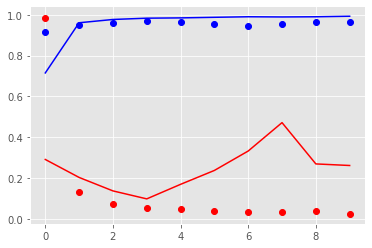

In [58]:
epochs=range(10)
plt.plot(epochs,loss,'ro',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="validation Loss")
plt.plot(epochs, val_accuracy,'bo',label="validation accuracy")
plt.plot(epochs,accuracy,'b',label="accuracy")
plt.savefig('graph')

In [59]:
predicted_classes=model.predict_classes(X_test)
predicted_classes[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


16

In [60]:
y_true=y_test
y_true[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [104]:
rounded_labels=np.argmax(y_test, axis=1)

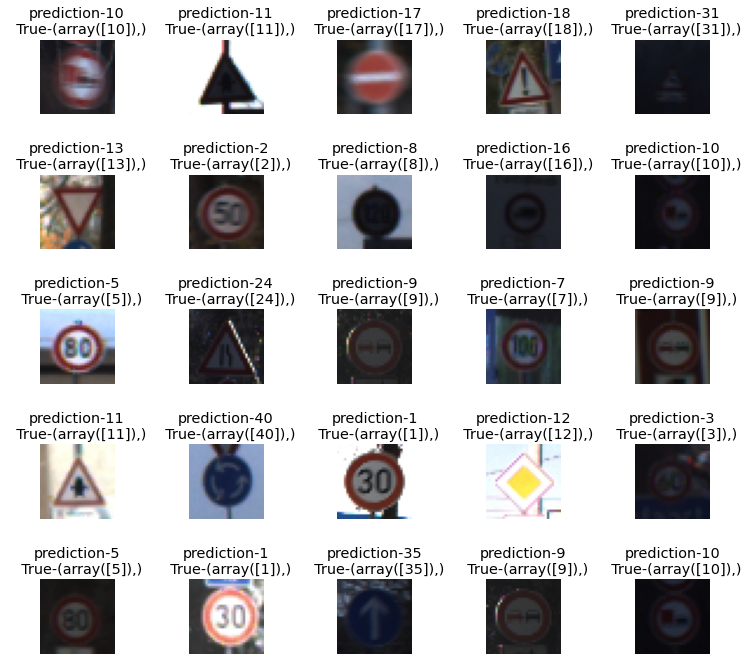

In [103]:
l=5
w=5
fig,axes=plt.subplots(l,w,figsize=(12,12))
axes=axes.ravel()
for i in np.arange(0,l*w):
  index=random.randint(0,12630)
  axes[i].imshow(X_test[index])
  axes[i].set_title('prediction-{}\n  True-{}'.format(predicted_classes[index],np.where(y_true[index]==1)))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1)


In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 96)        7296      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 112)       268912    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 112)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 112)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        64576     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)         

In [99]:
sign_name_df = pd.read_csv('/content/drive/My Drive/Traffic-Sign-Classification/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


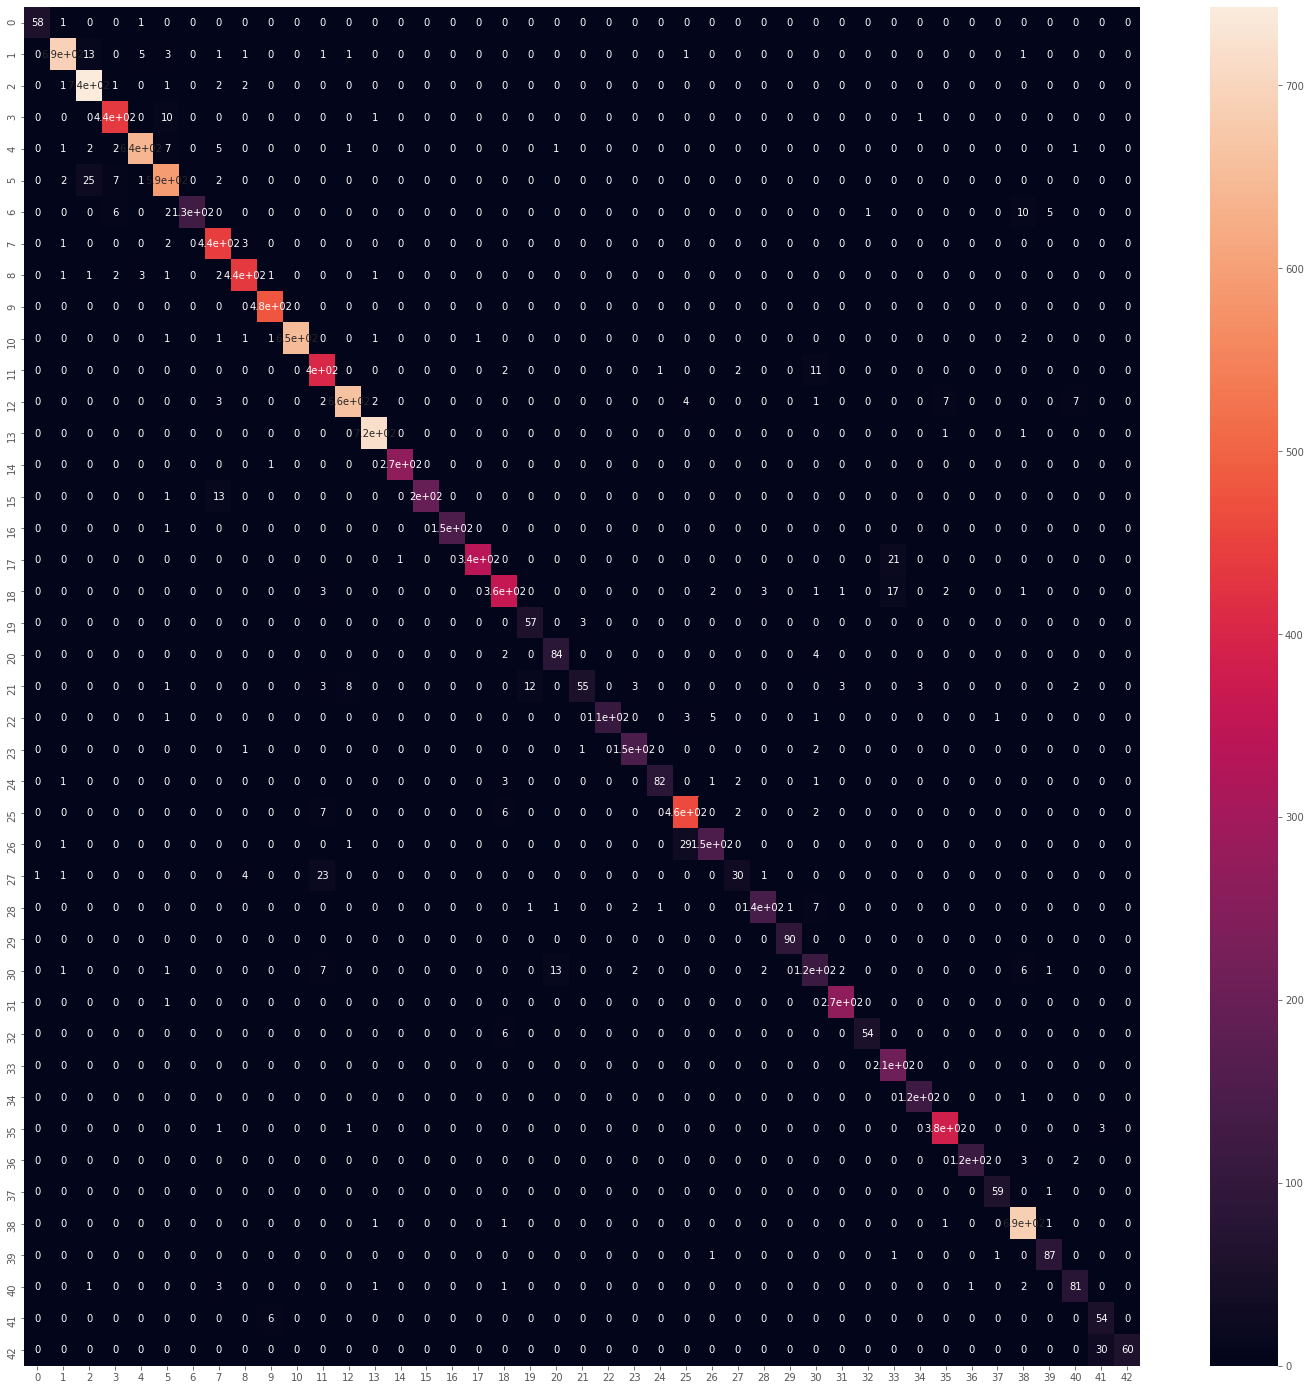

In [101]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(rounded_labels,predicted_classes)
plt.figure(figsize=(25,25))
import seaborn as sns
sns.heatmap(cm,annot=True)

**Feature Scope**

Future developments Better performance with higher framerate 

Use other approaches like YOLO or SSDDynamic image processingUse CNN to classification

No need to retrain the model when running theprogram

Make a bigger dataset